## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\Richard\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Richard\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Richard\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Richard\

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""Code Here
設定超參數
"""
LEARNING_RATE  = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.8

In [6]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    
    input_layer = keras.layers.Input([x_train.shape[-1]])
    x = keras.layers.Dense(units=512, activation="relu")(input_layer)
    x = keras.layers.Dense(units=512, activation="relu")(x)
    x = keras.layers.Dense(units=256, activation="relu")(x)
    x = keras.layers.Dense(units=256, activation="relu")(x)
    x = keras.layers.Dense(units=128, activation="relu")(x)
    x = keras.layers.Dense(units=128, activation="relu")(x)
    out = keras.layers.Dense(units=10, activation="softmax")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 128)      

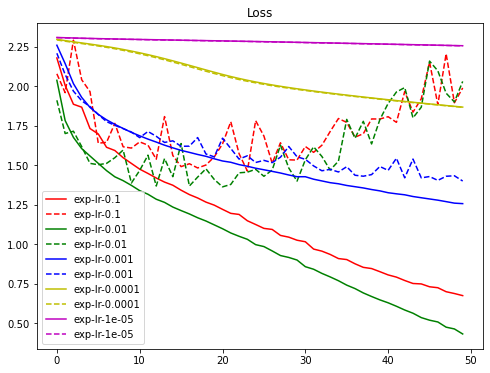

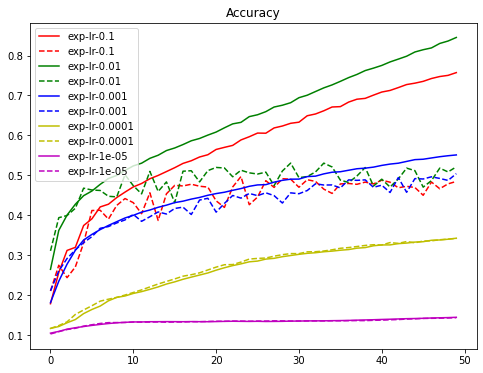

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()